## Week - 8 - Deep Neural Nets and Text

In this week we introduce the use of Deep Neural Networks to work with text. We have already seen some uses of neural networks for text in our classification HW, where we used a simple neural network--the one-layer perceptron--to classify text. It performed quite well, but comes up short in more sophisticated classification tasks, such as in predicting intent. We have also seen slightly deeper, 2-level neural nets in the form of word embeddings such as Word2Vec. While they work well, they have some drawbacks, such as representing words with multiple meanings in a singular space. 

BERT, which is a language model built using bidirectional encoders, allows us to take advantage of a powerful pre-trained model which we can then use to perform our own tasks based on data we analyze. 

In this notebook we use ```huggingface/transformers```, a python package that allows for easy interface to use pre-trained BERT models. It is built using Tensorflow and PyTorch, two computational graph packages which are built specifically for creating powerful neural networks. We will also be introducing Keras, which allows us to easily build Neural Networks in an abstracted way. Keras is a popular way to understand how we can stack layers to create such Neural Networks, but to reach state-of-the-art results we will stick with using BERT and similar models that can be tuned to extremely high performance on specific language understanding and generation tasks.

To demonstrate this, we begin by using the [Corpus of Linguistic Acceptability](https://nyu-mll.github.io/CoLA/). We will also use BERT by learning how to extract embeddings from such a model and use it to semantically probe sentences. There are a number of new packages and methods we will be using so be sure to update lucem_illud_2020.

## NOTE

This notebook **requires** GPUs for training models in section 1 and section 3. To train models, please use this [Google Colab file](https://colab.research.google.com/drive/1_G6iGqiXb-zPBTurRxd7cgGrXyNaKGsA) to create the models. Note that I have only given you view access: please create your own colab file to train your models, using the code and instructions I have given in the Colab file. So while you have to do the homework on this notebook, the models which you will train should be done on Google Colab, which has GPU access. If you happen to have GPU access on your personal machines or some other way to train the models, you are welcome to do that too.

Note that if you run the computationally intensive models on your local computer they will take a long time!

In [ ]:
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [ ]:
%matplotlib inline

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

## CoLA Dataset and pre-processing

We start with loading our dataset and pre-processing it. The pre-processing follows similar steps as we have done in the past, but we will be using pre-written modules offered by the transformers package. These are some of the things we have to take care of when using this particular BERT model.

    -special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
    -tokens that conforms with the fixed vocabulary used in BERT
    -token IDs from BERT’s tokenizer
    -mask IDs to indicate which elements in the sequence are tokens and which are padding elements
    -segment IDs used to distinguish different sentences
    -positional embeddings used to show token position within the sequence


We will be using parts of the code from [this notebook](https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=BJR6t_gCQe_x) which walks us through the process of using a pre-trained BERT model. The interface to use these models comes from the package [huggingface/transformers](https://github.com/huggingface/transformers). 

We start by setting up our GPU if we can - this may not work on your machine, so it has been commented out.

An aside: check out this tutorial too - https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [ ]:
gpu = torch.cuda.is_available()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [ ]:
device

In [ ]:
df = pd.read_csv("../data/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [ ]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

### Introducing Deep Neural Nets

A popular, simplified package for introducing deep neural networks is [Keras](https://keras.io). It is a high level package in that we don't bother with every detail or hyper-parameter associated with the neural network (e.g., regularizers), and can stack on layers directly. For a rapid tutorial on neural networks for text such as the LSTM or the Recurrent Neural Network, Colah's blog is a great start. [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is an article on LSTMs, and if you'd like to  learn about RNN, Andrej Karpathy does a great job in [this blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), in addition to our reading from the newest online verion of Jurafsky & Martin's review of deep learning methods in their book on speech and language processing, chapters [6,7,9,10](https://web.stanford.edu/~jurafsky/slp3/), and the [*Deep Learning*](https://www.deeplearningbook.org/) book by Goodfellow, Bengio & Courville.

In the following cells we build a basic deep net that has an embedding layer and an LSTM to perform classification. This is to illustrate the process of using Keras, which is a very popular library for such work. It may not yield state of the art performance because it constrains the hyperparameters you can tune, but is nonetheless an useful tool and works well on some datasets.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [ ]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

In [ ]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

We can see that the accuracy of this model isn't terrible, but it still hovers around 70%. Below there is code for a slightly modified neural network - how does this one perform? Note that in this model, I have added another LSTM layer. You are encouraged to explore the [Keras documentaion](https://keras.io/layers/about-keras-layers/) to explore what kind of layers you can add and how they change performances for different tasks. Different kinds of losses, optimizers, activations and layers can change the flavour of your net dramatically.

In [ ]:
# model_lstm2 = Sequential()
# model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
# model_lstm2.add(LSTM(units))
# model_lstm2.add(LSTM(units))
# model_lstm2.add(Dense(1, activation='sigmoid'))
# model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history_lstm2 = model_lstm2.fit(input_data_train, labels, epochs=10, batch_size=batch_size)

### On with BERT!

So while Neural Networks can do a good job with some kind of classification tasks, they don't perform too well on intent classification. Let us see how a bidirectional transformer embedding like BERT might do. 

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Loading our Models

### Train Model
Now that our input data is properly formatted, it's time to fine tune the BERT model.
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.
We'll load BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.

### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.
Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

Credit to Michel Kana's [tutorial](https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03) and the [tutorial](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=GuE5BqICAne2) by Chris McCormick and Nick Ryan who describe the workings of BERT and the way it is used by the ```transformers``` package. 

## WARNING: SHIFT TO A GPU ENABLED MACHINE (e.g., Google Colab)

Note that you only want to run the following code if you have a GPU. Otherwise, rerun the **same** cells we just ran on the Colab file to train your model, download it to your local, and load it by running
```model = BertForSequenceClassification.from_pretrained("my_model_directory", num_labels=2)```.


In [ ]:
model = BertForSequenceClassification.from_pretrained("model", num_labels=2)
# model.cuda()

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## COME BACK TO THIS NOTEBOOK to load and work with your trained model

Once you tune your model on Colab (or on your own machine if you decided to do that instead), you load it here.

In [ ]:
model = BertForSequenceClassification.from_pretrained("model", num_labels=2)

In [ ]:
import pandas as pd

In [ ]:
from sklearn.metrics import matthews_corrcoef

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

<span style="color:red">***Stretch***</span>: <span style="color:red">Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

## NOTE

This results from this notebook (and the corresponding one on Colab) were used for the coding presentation. As my project involves fitting four models for every task, not just one, and because the models can be very big (my machine lacks space and becomes very slow), I have not included all the models here from my coding presentation analysis (which was all performed mostly on Colab).

Also, the example code preceding the exercises in the original notebook is omitted from the rest of notebook.

The classification task performed through this notebook involved predicted personality labels from the Twitter likes dataset
I've been working on in past assignments. Some key results from the classification task are:

- The LSTM performs poorly across all the four binary variables of interest in the prediction task.
 Visualized below is classification for the variable 'intuitive'. As you can see, it performs very slightly better than chance.
- The BERT-based classifier performed much better on this front - achieving an accuracy of nearly 2/3 rds on the same task, on the validation set. (Only the Matthews coefficient (0.33) is shown below, the validation accuracy is from Colab.)

In [231]:
df = pd.read_csv('personality_likes_raw.csv', encoding='cp1252', index_col = 0)

df, test_df = train_test_split(df, test_size= 0.1)

In [232]:
# Create sentence and label lists
sentences = df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.intuitive.values

In [233]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', '/', '?', '.', '.', '.', 'ix', '##fp', ':', '(', ')', 'https', ':', '/', '/', 't', '.', 'co', '/', 'f', '##zu', '##sea', '##pl', '##ag', ',', ',', '.', '.', 'https', ':', '/', '/', 't', '.', 'co', '/', 'ox', '##ao', '##yi', '##2', '##v', '##v', '##5', '(', 'yi', '##zh', '##eng', 'ke', ')', '.', '.', 'https', ':', '/', '/', 't', '.', 'co', '/', 'co', '##9', '##8', '##w', '##j', '##r', '##8', '##t', '##0', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'https', ':', '/', '/', 't', '.', 'co', '/', '2', '##sz', '##5', '##rl', '##0', '##h', '##f', '##n', '3', ':', '.', 'https', ':', '/', '/', 't', '.', 'co', '/', '4', '##m', '##v', '##ho', '##ca', '##z', '##fk', '##1', '?', '.', '.', '.', '2', '.', '.', '.', '.', '.', '.', '.', '.', '.', '3', '3', 'https', ':', '/', '/', 't', '.', 'co', '/', 'y', '##6', '##h', '##8', '##b', '##pp', '##9', '##by', '.', '.', '.', 'https', ':', '/', '/', 't', '.', 'co', '/', 'b', '##5', '##dm', '##i', '##9', '##sil', '##k',

In [234]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [235]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [236]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [237]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [238]:
labels = df.intuitive.values
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

In [239]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [240]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           976704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [241]:
history_lstm = model_lstm.fit(train_inputs, train_labels,
                              epochs=10,batch_size=32)

Epoch 1/10
39/39 [==============================] - 8s 83ms/step - loss: 0.6934 - accuracy: 0.4921

In [242]:
preds = [0 if i[0]> i[1] else 1 for i in model_lstm.predict(validation_inputs)]

In [243]:
from sklearn.metrics import accuracy_score

accuracy_score(preds, validation_labels)

0.5323741007194245

## BERT

In [244]:
model = BertForSequenceClassification.from_pretrained("intuitive_model", num_labels=2)

### Holdout Set

In [245]:
import pandas as pd



# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
sentences = test_df.text.values
sentences = [i[:128] for i in sentences]
labels = test_df.intuitive.values


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

prediction_labels = torch.tensor(labels)
# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 154



In [246]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch


    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
      b_input_ids = b_input_ids.type(torch.LongTensor)
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 154 test sentences...
    DONE.


In [247]:
print('Positive samples: %d of %d (%.2f%%)' % (test_df.intuitive.sum(),
                                               len(test_df.intuitive), (test_df.intuitive.sum() / len(test_df.intuitive) * 100.0)))

Positive samples: 72 of 154 (46.75%)


In [248]:
prediction = []
for pred in predictions:

  prediction += [0 if x[0]>x[1] else 1 for x in pred]

In [249]:
 np.argmax(predictions[0], axis=1).flatten()

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0], dtype=int64)

In [250]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
 ##   print(pred_labels_i)


    # Calculate and store the coef for this batch.
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [251]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)


MCC: 0.325


Some useful functions for later:

In [252]:
from transformers import BertModel

In [253]:
from scipy.spatial.distance import cosine

In [254]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [255]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

The huggingface/transformers repository lists the other pipeline functions, such as ner extraction, sequence classification, and masking. You are encouraged to explore them. 
https://github.com/huggingface/transformers#quick-tour-of-pipelines

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

### Using Transformers Pipelines

We use the sentiment analysis pipeline to calculate the average sentiments expressed across each of the four personality traits.
Interestingly, the most major difference in expression of sentiment was seen across the Judging/Perceiving variable -> Judgers were 50% more likely to like tweets expressing positive sentiment.
Feeling preference individuals were about 16% more likely to like positive sentiment tweets than those with a thinking preference.

There is little difference across I/E. Taken together, these results are interesting and worth investigating further. BERT generates high quality
sentiment scores, so these should be highly insightful. Prior methods would either be too slow (manual) or inacccurate (other older NLP pipelines).

The feature extraction pipeline is less useful for the analysis of the twitter personality dataset; majority of the analysis focusses on the sentiment scores and QA analysis.

In [219]:
from transformers import pipeline

In [220]:
##Allocate a pipeline for sentiment-analysis
nlp_sentiment = pipeline('sentiment-analysis')

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-finetuned-sst-2-english-modelcard.json' to download model card file.
Creating an empty model card.


In [221]:
def trunc(x):
    return x[:200]

In [222]:
i_text = df[df['extravert'] == 0]['text'].sample(400, random_state = 42).map(lambda x: trunc(x)).tolist()
e_text = df[df['extravert'] == 1]['text'].sample(400, random_state = 42).map(lambda x: trunc(x)).tolist()

In [223]:
n_text = df[df['intuitive'] == 1]['text'].sample(400, random_state = 42).map(lambda x: trunc(x)).tolist()
s_text = df[df['intuitive'] == 0]['text'].sample(400, random_state = 42).map(lambda x: trunc(x)).tolist()

In [224]:
f_text = df[df['thinking'] == 0]['text'].sample(400, random_state = 42).map(lambda x: trunc(x)).tolist()
t_text = df[df['thinking'] == 1]['text'].sample(400, random_state = 42).map(lambda x: trunc(x)).tolist()

In [225]:
p_text = df[df['judging'] == 0]['text'].sample(400, random_state = 42).map(lambda x: trunc(x)).tolist()
j_text = df[df['judging'] == 1]['text'].sample(400, random_state = 42).map(lambda x: trunc(x)).tolist()

In [226]:
def percPositive(x):
    pos = 0
    neg = 0
    for i in x:
        sen = nlp_sentiment(i)
        if sen[0]['label'] == 'POSITIVE':
            pos += 1
        else:
            neg += 1
    return 100 * pos/(pos + neg)

In [227]:
print(percPositive(i_text))
print(percPositive(e_text))

38.5
38.25


In [228]:
print(percPositive(n_text))
print(percPositive(s_text))

40.75
35.5


In [229]:
print(percPositive(t_text))
print(percPositive(f_text))

35.75
41.5


In [230]:
print(percPositive(j_text))
print(percPositive(p_text))

46.25
31.75


# QA

Each of the types were asked the question 'What do I like to do?' with the liked tweets given as context.
There were some interesting (and disturbing) answers. Some of these were sort of representative of the personality type, most were not.

Types were also asked 'I love to?'

In [190]:
# Allocate a pipeline for question-answering
nlp_question = pipeline('question-answering')

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-distilled-squad-modelcard.json' to download model card file.
Creating an empty model card.


In [191]:
nlp_question({
'question': 'What do I like to do ?',
'context': ' '.join(i_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


{'score': 0.00410427773607816,
 'start': 4476,
 'end': 4500,
 'answer': 'looked at the show wiki,'}

In [192]:
nlp_question({
'question': 'What do I like to do ?',
'context': ' '.join(e_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


{'score': 0.00636751323047946,
 'start': 1483,
 'end': 1502,
 'answer': 'therapy litigation?'}

In [193]:
nlp_question({
'question': 'What do I like to do ?',
'context': ' '.join(n_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.2881278074151634,
 'start': 1070,
 'end': 1118,
 'answer': 'listen to eye of the tiger and get too riled up?'}

In [194]:
nlp_question({
'question': 'What do I like to do ?',
'context': ' '.join(s_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.37193972870325354,
 'start': 727,
 'end': 744,
 'answer': 'playing twister.I'}

In [195]:
nlp_question({
'question': 'What do I like to do ?',
'context': ' '.join(t_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.1814056794085097,
 'start': 284,
 'end': 308,
 'answer': 'shoot all these Blazers.'}

In [196]:
nlp_question({
'question': 'What do I like to do ?',
'context': ' '.join(f_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.6977528588004631,
 'start': 3904,
 'end': 3933,
 'answer': 'drive out what he represents.'}

In [197]:
nlp_question({
'question': 'What do I like to do ?',
'context': ' '.join(j_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


{'score': 0.47051690860325834,
 'start': 4527,
 'end': 4551,
 'answer': 'shutter such a mind fuck'}

In [198]:
nlp_question({
'question': 'What do I like to do ?',
'context': ' '.join(p_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.0928724932157099,
 'start': 1985,
 'end': 2000,
 'answer': 'sea shanties...'}

I love to ?

In [199]:
# Allocate a pipeline for question-answering
nlp_question = pipeline('question-answering')

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-distilled-squad-modelcard.json' to download model card file.
Creating an empty model card.


In [200]:
nlp_question({
'question': 'I love to?',
'context': ' '.join(i_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.00014757042162302086,
 'start': 3828,
 'end': 3866,
 'answer': 'week.Spreading love on your timeline.'}

In [201]:
nlp_question({
'question': 'I love to?',
'context': ' '.join(e_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 3.483897437971876e-05,
 'start': 1139,
 'end': 1162,
 'answer': '“America the Beautiful”'}

In [202]:
nlp_question({
'question': 'I love to?',
'context': ' '.join(n_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 9.85067531132644e-05,
 'start': 4719,
 'end': 4735,
 'answer': 'Love you, Miche.'}

In [203]:
nlp_question({
'question': 'I love to?',
'context': ' '.join(s_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.0245091108148372,
 'start': 1005,
 'end': 1014,
 'answer': '@Amarisse'}

In [204]:
nlp_question({
'question': 'I love to?',
'context': ' '.join(t_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.02472686240653843,
 'start': 2254,
 'end': 2309,
 'answer': 'We are head over heels in love with this little nugget!'}

In [205]:
nlp_question({
'question': 'I love to?',
'context': ' '.join(f_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.00020052910111982222,
 'start': 2974,
 'end': 3012,
 'answer': 'up.Thank you to the frontline workers,'}

In [206]:
nlp_question({
'question': 'I love to?',
'context': ' '.join(j_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 998.64it/s]


{'score': 0.0004658211877896501,
 'start': 2498,
 'end': 2509,
 'answer': 'gorgeous...'}

In [207]:
nlp_question({
'question': 'I love to?',
'context': ' '.join(p_text)[:5000]
})

add example index and unique id: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'score': 0.001363327064610731,
 'start': 3630,
 'end': 3671,
 'answer': 'https://t.co/NIPWZECKrO@LOVE_ME_T__T'}

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?


# NOTE

While the RoBERTa models were successfully trained on the data and ran on my machine as well as on Colab, the GPT models would not run on my machine. I was not able to solve this issue even after discussing this very issue with Bhargav.
However, the GPT model was trained successfully ('GPT_N' and 'GPT_S') and ran on Colab (with the very same code below), the results of which are contained in the coding presentation.


In [208]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_N

2021-03-10 18:33:16.941428: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-03-10 18:33:16.941786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
03/10/2021 18:33:20 - WARNING - __main__ -   device: cpu, n_gpu: 0, 16-bits training: False
03/10/2021 18:33:20 - INFO - transformers.tokenization_utils -   Model name 'output_gpt_N' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'output_gpt_N' is a path, a model identifier, or url to a directory containing tokenizer files.
03/10/2021 18:33:20 - INFO - transformers.tokenization_utils -   Didn't find file output_gpt_N\added_tokens.json. We won't load it.
03/10/2021 18:33:20 - INFO - transformers.tokenization_utils -   loading file output_gpt_N\vocab.json
03/10/2021 18:33:20 - INFO - transformers.tokeniz

In [264]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=GPT_S

2021-03-10 18:53:00.937752: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-03-10 18:53:00.938893: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
03/10/2021 18:53:07 - WARNING - __main__ -   device: cpu, n_gpu: 0, 16-bits training: False
03/10/2021 18:53:07 - INFO - transformers.tokenization_utils -   Model name 'GPT_S' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'GPT_S' is a path, a model identifier, or url to a directory containing tokenizer files.
03/10/2021 18:53:07 - INFO - transformers.tokenization_utils -   Didn't find file GPT_S\added_tokens.json. We won't load it.
03/10/2021 18:53:07 - INFO - transformers.tokenization_utils -   loading file GPT_S\vocab.json
03/10/2021 18:53:07 - INFO - transformers.tokenization_utils -   loading file

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?


Three texts were fed into two RoBERTa models (low and high openness individuals) to understand how they associate a word more commonly used with ordinary meanings related to a usage in a more abstract domain.
This fits with the theme of investigating low and high openness individuals - high openness individuals may show more association to the abstract theme usage of the words in question.

The results do not show significant differences between the plots, so it is not possible for us to test the hypotheses that we laid out above. We may need more powerful tests/more data to dsitinguish the differences between individuals that we hypothesize.

However some promising signs can be seen in the plots, for example, the association between 'learning' and 'machine' is stronger in the intuitives model as compared to the non intuitives model, which is exactly the kind of effect that we would expect.

In [210]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [211]:
roberta_us_model_embedding = RobertaModel.from_pretrained('Roberta_N')


In [212]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [213]:
text1 = "I love science, technology, and healthcare!." # To understand how low and high openness individuals view healthcare when compared to science/technology.
text2 = "This is the latest ARM CPU balancing on my hand." # To see how ARM is related to CPU or a bodily appendage, across high and low openness individuals.
text3 = "Should I train my machine learning model or my dog?" # To understand how 'train' relates to machines as compared to a  dog, across high and low openness individuals.
text4 = "Was the bog closer to the forest or the house?" # stock sentence
text5 = "Are you taking the trolley or the train to the grocery market" # stock sentence

In [214]:
import seaborn as sns

In [215]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

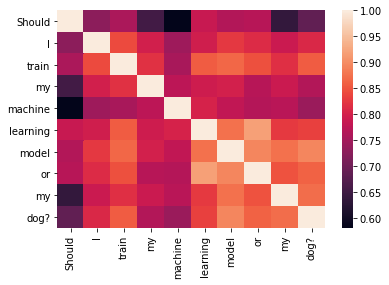

In [216]:
visualise_diffs(text3, roberta_us_model_embedding, roberta_us_tokenizer)

In [217]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('Roberta_S')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

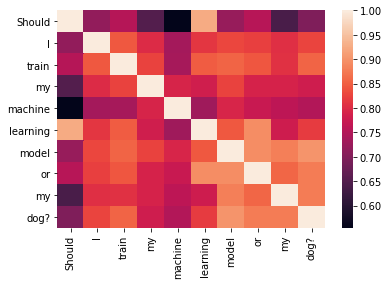

In [218]:
visualise_diffs(text3, roberta_gb_model_embedding, roberta_gb_tokenizer)
